In [2]:
import torch
import numpy as np
from PIL import Image, ImageDraw
from torchvision.transforms.functional import to_pil_image
from facenet_pytorch.models.mtcnn import PNet, RNet, ONet  # Import P-Net, R-Net, O-Net
from facenet_pytorch import MTCNN
import os
import matplotlib.pyplot as plt
from facenet_pytorch import InceptionResnetV1
import cv2


In [3]:
match_images_folder = r'D:\Images\Facial_reco_images\Facial_reco_images\Game'  # match photos
studio_images_folder = r'D:\Images\Facial_reco_images\Facial_reco_images\Players\Studio_photos'  # studio photos

In [4]:
# Define fine-tuned P-Net, R-Net, and O-Net for finetuning
class FinetunedMTCNN(MTCNN):
#(self, image_size=160, margin=5, **kwargs): # use this after some time to improve the final results
    def __init__(self, image_size=160, margin=15, **kwargs):
        super(FinetunedMTCNN, self).__init__(**kwargs)
        # Create your custom, finetuned P-Net, R-Net, O-Net here
        self.pnet = PNet()
        self.rnet = RNet()
        self.onet = ONet()
    def forward(self, x):
        # Overriding forward pass if additional finetuning is needed
        return super().forward(x)

In [5]:
# Initialize FaceNet model
facenet = InceptionResnetV1(pretrained='vggface2').eval()  # Load the FaceNet model
# Initialize mtcnn model
finetuned_mtcnn = FinetunedMTCNN(keep_all=True, device='cuda:0' if torch.cuda.is_available() else 'cpu', min_face_size=60)

In [6]:
# Function to perform face detection, apply NMS, and save cropped face images
def process_and_save_match_faces(image_folder, mtcnn_model):
    global match_photos_all
    match_photos_all = []
    for filename in os.listdir(image_folder):
        if filename.endswith(".jpeg"):
            image_path = os.path.join(image_folder, filename)
            image = Image.open(image_path)
            # Detect faces (with bounding boxes, probabilities, and landmarks)
            boxes, confidences, landmarks = mtcnn_model.detect(image, landmarks=True)
            if boxes is not None:
                # Set a confidence threshold
                threshold = 0.96
                # Filter detected faces based on the confidence score
                filtered_faces = [i for i, confidence in enumerate(confidences) if confidence > threshold]
                # Save cropped faces that pass the confidence threshold
                for i in filtered_faces:
                    box = boxes[i]  # Get the bounding box for the filtered face
                    # Crop the face using the O-Net bounding box
                    cropped_face = image.crop(box)
                    match_photos_all.append(cropped_face)
    return match_photos_all

In [7]:
def process_and_save_studio_faces(image_folder, mtcnn_model):
    global studio_photos_all
    studio_photos_all = []
    for filename in os.listdir(image_folder):
        if filename.endswith(".jpeg"):
            image_path = os.path.join(image_folder, filename)
            image = Image.open(image_path)
            # Detect faces (with bounding boxes, probabilities, and landmarks)
            boxes, confidences, landmarks = mtcnn_model.detect(image, landmarks=True)
            if boxes is not None:
                # Set a confidence threshold
                threshold = 0.96
                # Filter detected faces based on the confidence score
                filtered_faces = [i for i, confidence in enumerate(confidences) if confidence > threshold]
                # Save cropped faces that pass the confidence threshold
                for i in filtered_faces:
                    box = boxes[i]  # Get the bounding box for the filtered face
                    # Crop the face using the O-Net bounding box
                    cropped_face = image.crop(box)
                    studio_photos_all.append(cropped_face)
    return studio_photos_all

In [8]:
# Function to get face embeddings from a pre-cropped face image
def get_face_embedding(image):
    image = cv2.resize(image, (160, 160))  # Resize to 160x160 as required by FaceNet
    image = torch.tensor(image).permute(2, 0, 1).unsqueeze(0).float() / 255.0  # Convert to tensor, normalize
    embedding = facenet(image)  # Get the embedding
    return embedding.detach().numpy()  # Convert to numpy array

In [9]:
# Function to calculate Euclidean distance between embeddings
def euclidean_distance(embedding1, embedding2):
    return np.linalg.norm(embedding1 - embedding2)

In [10]:
# 4. Process both match and studio images
process_and_save_studio_faces(studio_images_folder, finetuned_mtcnn)
studio_image_shapes = [np.array(image).shape for image in studio_photos_all]
print("Shapes of images in the list studio_photos_all:", studio_image_shapes)
print(f"shape of studio_photos: {len(studio_photos_all)}")

Shapes of images in the list studio_photos_all: [(982, 779, 3), (963, 760, 3), (1077, 823, 3), (824, 643, 3), (902, 680, 3), (808, 681, 3), (930, 717, 3), (1060, 841, 3), (936, 757, 3), (868, 713, 3), (901, 725, 3), (931, 811, 3)]
shape of studio_photos: 12


In [11]:
# Generate embeddings for studio photos (using studio_photos_all list)
studio_embeddings = []
for i, studio_photo in enumerate(studio_photos_all):
    studio_image = np.array(studio_photo)  # Convert the PIL image to a NumPy array
    embedding = get_face_embedding(studio_image)  # Get embedding
    if embedding is not None:
        studio_embeddings.append((i, embedding))  # Store the index and embedding

In [12]:
process_and_save_match_faces(match_images_folder, finetuned_mtcnn)
match_image_shapes = [np.array(image).shape for image in match_photos_all]
print("Shapes of images in the list match_photos_all:", match_image_shapes)
print(f"shape of match_photos: {len(match_photos_all)}")

Shapes of images in the list match_photos_all: [(149, 132, 3), (110, 107, 3), (50, 42, 3), (36, 31, 3), (179, 149, 3), (182, 145, 3), (182, 144, 3), (177, 145, 3), (371, 289, 3), (331, 249, 3), (129, 80, 3), (296, 235, 3), (284, 265, 3), (306, 278, 3), (222, 184, 3), (222, 187, 3), (602, 466, 3), (147, 129, 3), (114, 105, 3), (50, 41, 3), (40, 32, 3), (290, 226, 3), (216, 185, 3), (180, 150, 3), (147, 138, 3), (267, 212, 3), (166, 142, 3), (157, 113, 3), (161, 135, 3), (149, 94, 3), (562, 422, 3), (133, 116, 3), (284, 216, 3), (150, 131, 3), (107, 94, 3), (56, 44, 3), (36, 31, 3), (292, 230, 3), (284, 222, 3), (269, 220, 3), (302, 245, 3), (196, 165, 3), (185, 149, 3), (290, 255, 3), (278, 256, 3), (283, 231, 3), (195, 141, 3), (268, 222, 3), (383, 325, 3), (251, 217, 3), (270, 229, 3), (230, 205, 3), (160, 145, 3), (158, 124, 3), (217, 157, 3), (490, 386, 3), (469, 347, 3), (178, 139, 3), (181, 142, 3), (169, 144, 3), (292, 242, 3), (217, 166, 3), (183, 142, 3), (304, 257, 3), (207, 1

In [13]:
# Generate embeddings for game photos (using match_photos_all list)
game_embeddings = []
for i, match_photo in enumerate(match_photos_all):
    match_image = np.array(match_photo)  # Convert the PIL image to a NumPy array
    embedding = get_face_embedding(match_image)  # Get embedding
    if embedding is not None:
        game_embeddings.append((i, embedding))  # Store the index and embedding

In [90]:
# Compare studio embeddings with game embeddings
results = {}
threshold = 0.75  # Define a similarity threshold for matches

In [91]:
for studio_idx, studio_embedding in studio_embeddings:
    matched_photos = []
    for game_idx, game_embedding in game_embeddings:
        distance = euclidean_distance(studio_embedding, game_embedding)
        if distance < threshold:  # If distance is below the threshold, consider it a match
            matched_photos.append((game_idx, distance))
    results[studio_idx] = matched_photos  # Store the matching game photos and distances


Matching game photos for studio photo index 0:
[(242, 0.57466614), (243, 0.5767892)]


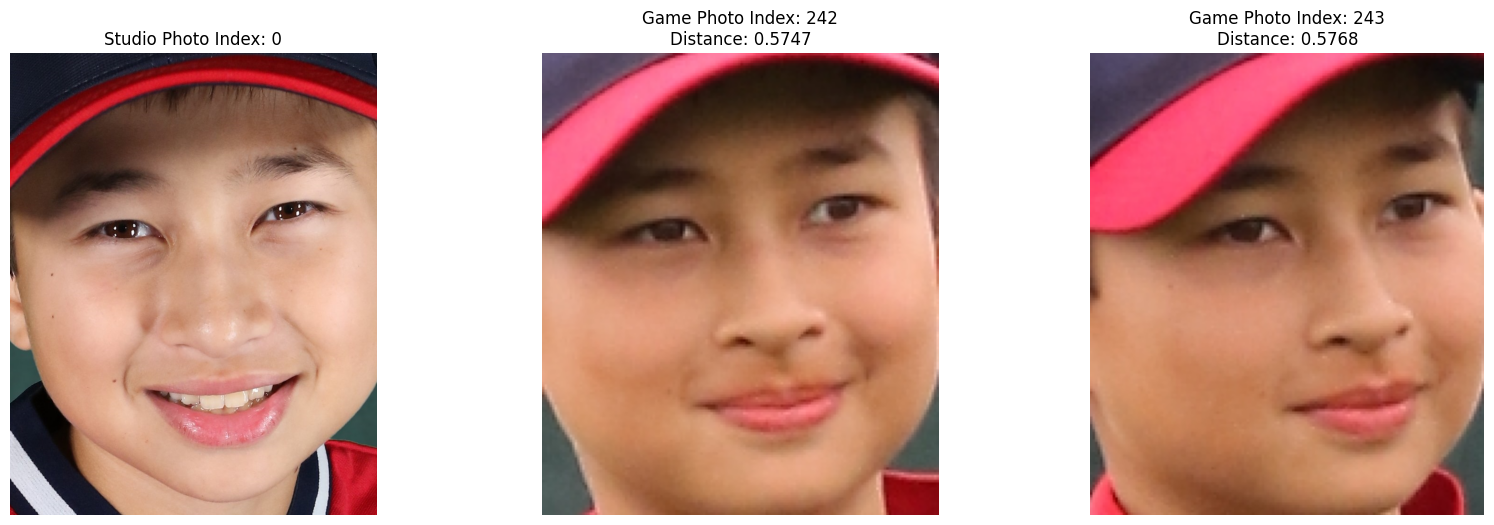

Matching game photos for studio photo index 1:
[(183, 0.7436489), (225, 0.7049069)]


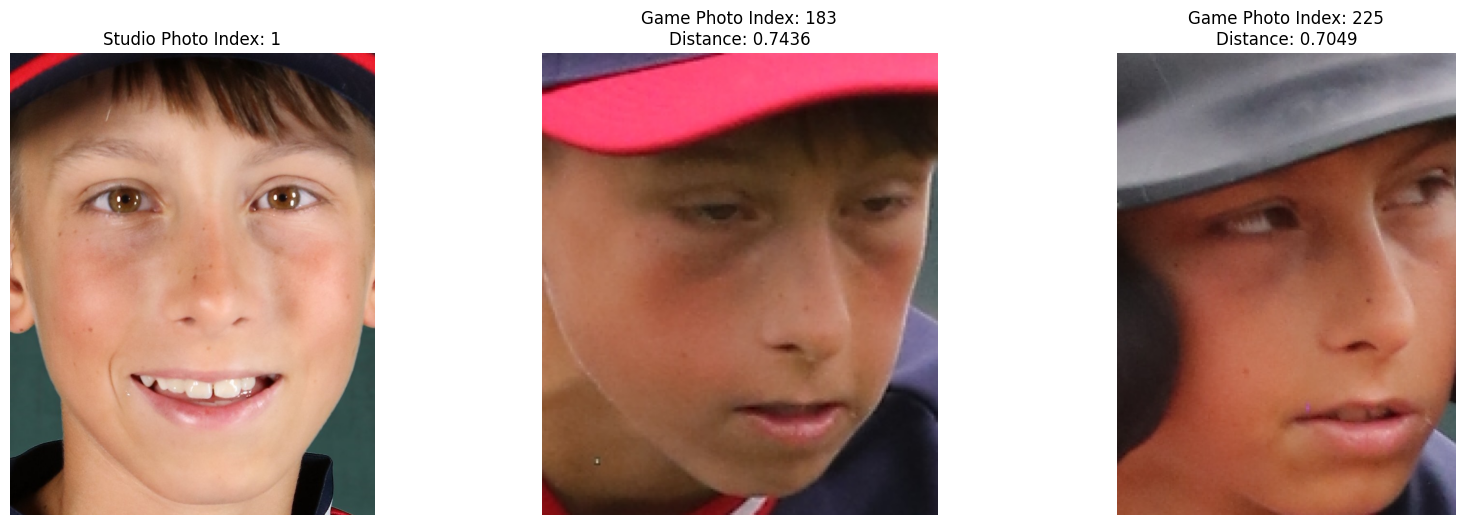

Matching game photos for studio photo index 2:
[(208, 0.70703334), (238, 0.6793468), (239, 0.6409427), (240, 0.60882086), (256, 0.67541456)]


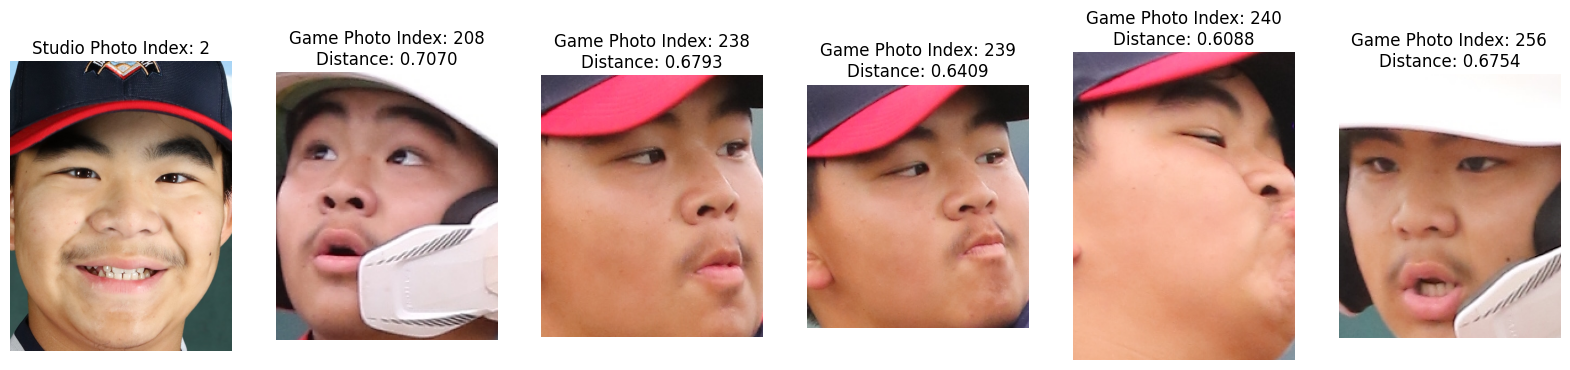

Matching game photos for studio photo index 3:
[]
No matches found.
Matching game photos for studio photo index 4:
[]
No matches found.
Matching game photos for studio photo index 5:
[]
No matches found.
Matching game photos for studio photo index 6:
[]
No matches found.
Matching game photos for studio photo index 7:
[(69, 0.57881784), (70, 0.6586753), (71, 0.64262986), (94, 0.58000886), (110, 0.5630007), (112, 0.60910773), (180, 0.70989555), (246, 0.6174384)]


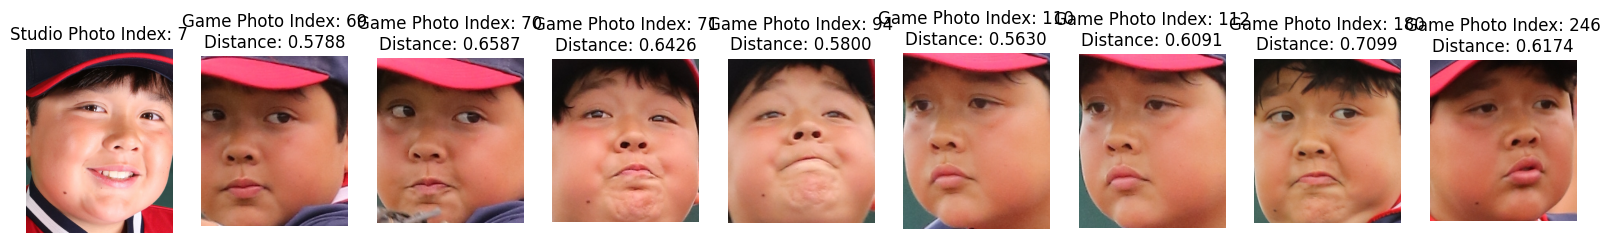

Matching game photos for studio photo index 8:
[]
No matches found.
Matching game photos for studio photo index 9:
[]
No matches found.
Matching game photos for studio photo index 10:
[]
No matches found.
Matching game photos for studio photo index 11:
[]
No matches found.


In [92]:
# Display results
for studio_idx, matches in results.items():
    print(f'Matching game photos for studio photo index {studio_idx}:')
    print(matches)  # List of matched game photos (indices and distances)
    # Visualizing the results
    if matches:
        # Get the studio image using the index
        studio_image = np.array(studio_photos_all[studio_idx])
        # Set up the plot for studio and matched game images
        plt.figure(figsize=(20, 6))
        plt.subplot(1, len(matches) + 1, 1)
        plt.imshow(studio_image)
        plt.title(f'Studio Photo Index: {studio_idx}')
        plt.axis('off')
        # Display each matched game image
        for i, (game_idx, distance) in enumerate(matches):
            game_image = np.array(match_photos_all[game_idx])  # Get the match image by index
            plt.subplot(1, len(matches) + 1, i + 2)
            plt.imshow(game_image)
            plt.title(f'Game Photo Index: {game_idx}\nDistance: {distance:.4f}')
            plt.axis('off')
        # Show the plot with studio and match images
        plt.show()
    else:
        print("No matches found.")


Shapes of images in the list studio_photos_all: [(982, 779, 3), (963, 760, 3), (1077, 823, 3), (824, 643, 3), (902, 680, 3), (808, 681, 3), (930, 717, 3), (1060, 841, 3), (936, 757, 3), (868, 713, 3), (901, 725, 3), (931, 811, 3)]
Number of studio photos: 12
Shapes of images in the list match_photos_all: [(149, 132, 3), (110, 107, 3), (50, 42, 3), (36, 31, 3), (179, 149, 3), (182, 145, 3), (182, 144, 3), (177, 145, 3), (371, 289, 3), (331, 249, 3), (129, 80, 3), (296, 235, 3), (284, 265, 3), (306, 278, 3), (222, 184, 3), (222, 187, 3), (602, 466, 3), (147, 129, 3), (114, 105, 3), (50, 41, 3), (40, 32, 3), (290, 226, 3), (216, 185, 3), (180, 150, 3), (147, 138, 3), (267, 212, 3), (166, 142, 3), (157, 113, 3), (161, 135, 3), (149, 94, 3), (562, 422, 3), (133, 116, 3), (284, 216, 3), (150, 131, 3), (107, 94, 3), (56, 44, 3), (36, 31, 3), (292, 230, 3), (284, 222, 3), (269, 220, 3), (302, 245, 3), (196, 165, 3), (185, 149, 3), (290, 255, 3), (278, 256, 3), (283, 231, 3), (195, 141, 3), (26

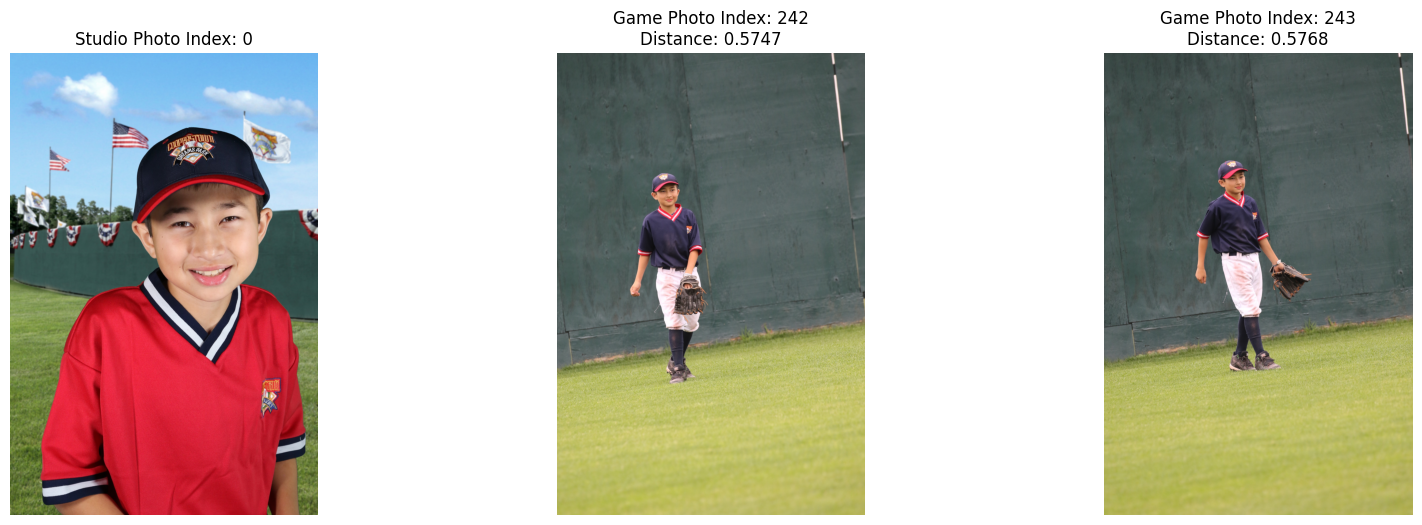

Matching game photos for studio photo index 1:
[(183, 0.7436489), (225, 0.7049069)]


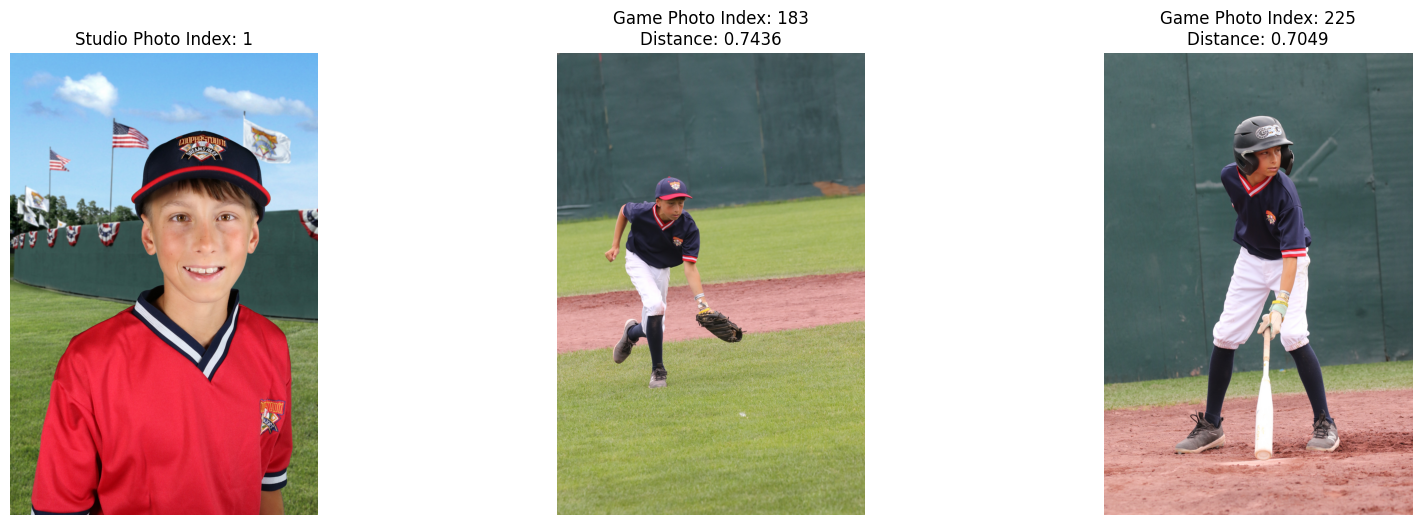

Matching game photos for studio photo index 2:
[(208, 0.70703334), (238, 0.6793468), (239, 0.6409427), (240, 0.60882086), (256, 0.67541456)]


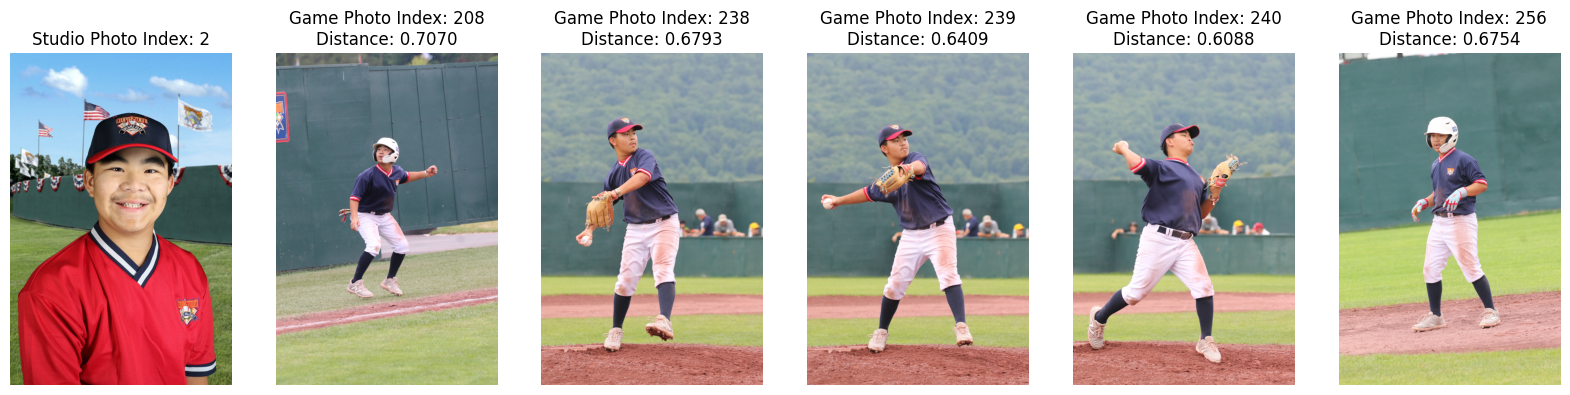

Matching game photos for studio photo index 3:
[]
No matches found.
Matching game photos for studio photo index 4:
[]
No matches found.
Matching game photos for studio photo index 5:
[]
No matches found.
Matching game photos for studio photo index 6:
[]
No matches found.
Matching game photos for studio photo index 7:
[(69, 0.57881784), (70, 0.6586753), (71, 0.64262986), (94, 0.58000886), (110, 0.5630007), (112, 0.60910773), (180, 0.70989555), (246, 0.6174384)]


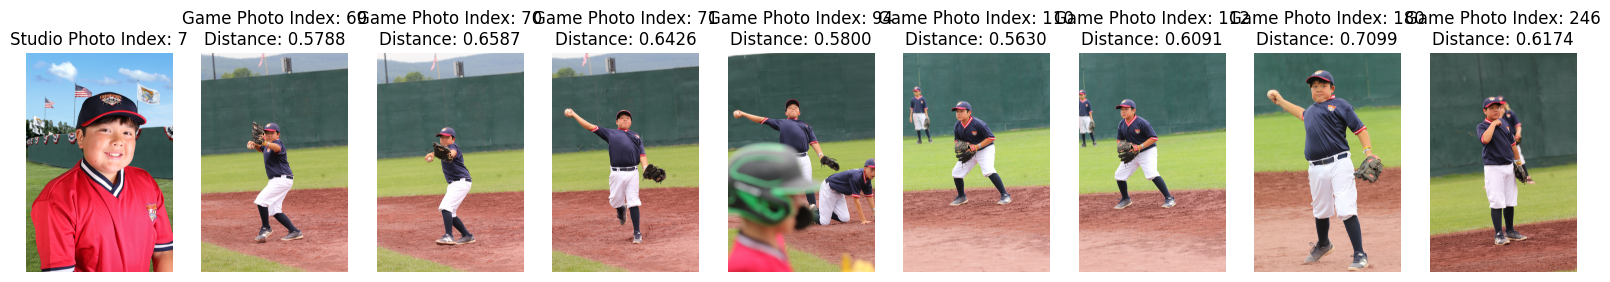

Matching game photos for studio photo index 8:
[]
No matches found.
Matching game photos for studio photo index 9:
[]
No matches found.
Matching game photos for studio photo index 10:
[]
No matches found.
Matching game photos for studio photo index 11:
[]
No matches found.


In [93]:
import torch
import numpy as np
from PIL import Image
from torchvision.transforms.functional import to_pil_image
from facenet_pytorch import InceptionResnetV1
import os
import matplotlib.pyplot as plt
import cv2

match_images_folder = r'D:\Images\Facial_reco_images\Facial_reco_images\Game'  # match photos
studio_images_folder = r'D:\Images\Facial_reco_images\Facial_reco_images\Players\Studio_photos'  # studio photos

# Define fine-tuned MTCNN class (no changes needed here)
class FinetunedMTCNN(MTCNN):
    def __init__(self, image_size=160, margin=15, **kwargs):
        super(FinetunedMTCNN, self).__init__(**kwargs)
        self.pnet = PNet()
        self.rnet = RNet()
        self.onet = ONet()

# Initialize FaceNet model
facenet = InceptionResnetV1(pretrained='vggface2').eval()  # Load the FaceNet model
# Initialize mtcnn model
finetuned_mtcnn = FinetunedMTCNN(keep_all=True, device='cuda:0' if torch.cuda.is_available() else 'cpu', min_face_size=60)


# Function to perform face detection and store image paths with their cropped face regions
def process_and_save_match_faces(image_folder, mtcnn_model):
    global match_photos_all
    match_photos_all = []
    match_photos_paths = []
    for filename in os.listdir(image_folder):
        if filename.endswith(".jpeg"):
            image_path = os.path.join(image_folder, filename)
            image = Image.open(image_path)
            # Detect faces (with bounding boxes, probabilities, and landmarks)
            boxes, confidences, landmarks = mtcnn_model.detect(image, landmarks=True)
            if boxes is not None:
                # Set a confidence threshold
                threshold = 0.96
                # Filter detected faces based on the confidence score
                filtered_faces = [i for i, confidence in enumerate(confidences) if confidence > threshold]
                # Save original image paths and face regions that pass the confidence threshold
                for i in filtered_faces:
                    box = boxes[i]  # Get the bounding box for the filtered face
                    cropped_face = image.crop(box)
                    match_photos_all.append(cropped_face)
                    match_photos_paths.append(image_path)  # Store original image path
    return match_photos_paths  # Return list of original image paths

def process_and_save_studio_faces(image_folder, mtcnn_model):
    global studio_photos_all
    studio_photos_all = []
    studio_photos_paths = []
    for filename in os.listdir(image_folder):
        if filename.endswith(".jpeg"):
            image_path = os.path.join(image_folder, filename)
            image = Image.open(image_path)
            # Detect faces (with bounding boxes, probabilities, and landmarks)
            boxes, confidences, landmarks = mtcnn_model.detect(image, landmarks=True)
            if boxes is not None:
                # Set a confidence threshold
                threshold = 0.96
                # Filter detected faces based on the confidence score
                filtered_faces = [i for i, confidence in enumerate(confidences) if confidence > threshold]
                # Save original image paths and face regions that pass the confidence threshold
                for i in filtered_faces:
                    box = boxes[i]  # Get the bounding box for the filtered face
                    cropped_face = image.crop(box)
                    studio_photos_all.append(cropped_face)
                    studio_photos_paths.append(image_path)  # Store original image path
    return studio_photos_paths  # Return list of original image paths

# Function to get face embeddings from a pre-cropped face image
def get_face_embedding(image):
    image = cv2.resize(image, (160, 160))  # Resize to 160x160 as required by FaceNet
    image = torch.tensor(image).permute(2, 0, 1).unsqueeze(0).float() / 255.0  # Convert to tensor, normalize
    embedding = facenet(image)  # Get the embedding
    return embedding.detach().numpy()  # Convert to numpy array

# Function to calculate Euclidean distance between embeddings
def euclidean_distance(embedding1, embedding2):
    return np.linalg.norm(embedding1 - embedding2)

# Process both match and studio images, and return original image paths
studio_photos_paths = process_and_save_studio_faces(studio_images_folder, finetuned_mtcnn)
studio_image_shapes = [np.array(image).shape for image in studio_photos_all]
print("Shapes of images in the list studio_photos_all:", studio_image_shapes)
print(f"Number of studio photos: {len(studio_photos_all)}")

# Generate embeddings for studio photos
studio_embeddings = []
for i, studio_photo in enumerate(studio_photos_all):
    studio_image = np.array(studio_photo)  # Convert the PIL image to a NumPy array
    embedding = get_face_embedding(studio_image)  # Get embedding
    if embedding is not None:
        studio_embeddings.append((i, embedding))  # Store the index and embedding

# Process and return original match photo paths
match_photos_paths = process_and_save_match_faces(match_images_folder, finetuned_mtcnn)
match_image_shapes = [np.array(image).shape for image in match_photos_all]
print("Shapes of images in the list match_photos_all:", match_image_shapes)
print(f"Number of match photos: {len(match_photos_all)}")

# Generate embeddings for match (game) photos
game_embeddings = []
for i, match_photo in enumerate(match_photos_all):
    match_image = np.array(match_photo)  # Convert the PIL image to a NumPy array
    embedding = get_face_embedding(match_image)  # Get embedding
    if embedding is not None:
        game_embeddings.append((i, embedding))  # Store the index and embedding

# Compare studio embeddings with match embeddings
results = {}
threshold = 0.75  # Define a similarity threshold for matches

for studio_idx, studio_embedding in studio_embeddings:
    matched_photos = []
    for game_idx, game_embedding in game_embeddings:
        distance = euclidean_distance(studio_embedding, game_embedding)
        if distance < threshold:  # If distance is below the threshold, consider it a match
            matched_photos.append((game_idx, distance))
    results[studio_idx] = matched_photos  # Store the matching game photos and distances

# Display results, but load and display the original images (using the file paths)
for studio_idx, matches in results.items():
    print(f'Matching game photos for studio photo index {studio_idx}:')
    print(matches)  # List of matched game photos (indices and distances)
    if matches:
        # Load and display the studio image using the file path
        studio_image = Image.open(studio_photos_paths[studio_idx])
        # Set up the plot for studio and matched game images
        plt.figure(figsize=(20, 6))
        plt.subplot(1, len(matches) + 1, 1)
        plt.imshow(studio_image)
        plt.title(f'Studio Photo Index: {studio_idx}')
        plt.axis('off')
        # Display each matched game image using the original file path
        for i, (game_idx, distance) in enumerate(matches):
            game_image = Image.open(match_photos_paths[game_idx])  # Load the match image by path
            plt.subplot(1, len(matches) + 1, i + 2)
            plt.imshow(game_image)
            plt.title(f'Game Photo Index: {game_idx}\nDistance: {distance:.4f}')
            plt.axis('off')
        # Show the plot with studio and match images
        plt.show()
    else:
        print("No matches found.")
